<a href="https://colab.research.google.com/github/jaehyun0220/Colab/blob/master/SDS_PublicData_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3조. 건강검진 데이터를 활용한 치아우식증 발생 예측
#### # Ver 8. ML 모델 선택

In [126]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#### #2. 작업환경 세팅

In [127]:
# woe package install
! pip install woe

In [0]:
# 기본 라이브러리 로드
import pandas as pd
import numpy as np
import os, sys

from tqdm import tqdm_notebook

import re
import tensorflow as tf

#데이터 전처리 관련 라이브러리 로드
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

#모델 알고리즘 로드
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

#차원축소 알고리즘 로드
from sklearn.decomposition import PCA

# Calculate IV Setting
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string
import woe
from woe.eval import plot_ks

# Deep Learning Model 로드
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.wrappers.scikit_learn import KerasClassifier

#HyperParameter Tuning을 위한 라이브러리 로드
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#모델 평가를 위한 라이브러리 로드
from sklearn import metrics, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

#수학 & 통계 관련 라이브러리 로드
import scipy.stats as st
from collections import Counter
import math

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

#### #3.사용할 사용자 함수 정의

In [0]:
def auc_graph(roc_auc, fpr, tpr):
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# Define a binning function for continous independent variables
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]
  r = 0
  while np.abs(r) < 1:
    try:
      global d1
      global d2
      d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
      d2 = d1.groupby('Bucket', as_index=True)
      r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
      n = n - 1 
    except Exception as e:
      n = n - 1
      break
      
  if len(d2) == 1:
    n = force_bin         
    bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
    if len(np.unique(bins)) == 2:
        bins = np.insert(bins, 0, 1)
        bins[1] = bins[1]-(bins[1]/2)
    d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
    d2 = d1.groupby('Bucket', as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["MIN_VALUE"] = d2.min().X
  d3["MAX_VALUE"] = d2.max().X
  d3["COUNT"] = d2.count().Y
  d3["EVENT"] = d2.sum().Y
  d3["NONEVENT"] = d2.count().Y - d2.sum().Y
  d3=d3.reset_index(drop=True)

  if len(justmiss.index) > 0:
      d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
      d4["MAX_VALUE"] = np.nan
      d4["COUNT"] = justmiss.count().Y
      d4["EVENT"] = justmiss.sum().Y
      d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
      d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()

  return(d3)
  
# Define a binning function for categorical independent variables
def char_bin(Y, X):
  df1 = pd.DataFrame({"X": X, "Y": Y})
  justmiss = df1[['X','Y']][df1.X.isnull()]
  notmiss = df1[['X','Y']][df1.X.notnull()]    
  df2 = notmiss.groupby('X',as_index=True)

  d3 = pd.DataFrame({},index=[])
  d3["COUNT"] = df2.count().Y
  d3["MIN_VALUE"] = df2.sum().Y.index
  d3["MAX_VALUE"] = d3["MIN_VALUE"]
  d3["EVENT"] = df2.sum().Y
  d3["NONEVENT"] = df2.count().Y - df2.sum().Y

  if len(justmiss.index) > 0:
    d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
    d4["MAX_VALUE"] = np.nan
    d4["COUNT"] = justmiss.count().Y
    d4["EVENT"] = justmiss.sum().Y
    d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
    d3 = d3.append(d4,ignore_index=True)

  d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
  d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
  d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
  d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
  d3["VAR_NAME"] = "VAR"
  d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
  d3 = d3.replace([np.inf, -np.inf], 0)
  d3.IV = d3.IV.sum()
  d3 = d3.reset_index(drop=True)

  return(d3)

# Calculate Information Values
def calc_iv_all(df1, target):
    
  stack = traceback.extract_stack()
  filename, lineno, function_name, code = stack[-2]
  vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
  final = (re.findall(r"[\w']+", vars_name))[-1]

  x = df1.dtypes.index
  count = -1

  for i in tqdm_notebook(x):
    if i.upper() not in (final.upper()):
      if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
        conv = mono_bin(target, df1[i])
        conv["VAR_NAME"] = i
        count = count + 1
      else:
        conv = char_bin(target, df1[i])
        conv["VAR_NAME"] = i            
        count = count + 1

      if count == 0:
        iv_df = conv
      else:
        iv_df = iv_df.append(conv,ignore_index=True)

  iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
  iv = iv.reset_index()
  return(iv_df,iv)

#### #4.원천 데이터 load 및 seed 설정

In [130]:
set_random_seed = 2580 # seed 지정
target_nm = 'dental_carries' # 타겟 변수 지정

#### 2013년 기준 #########################################################################################################################################
df_raw_2013 = pd.read_csv('../gdrive/My Drive/sds/data/NHIS_OPEN_GJ_2013_eng.csv', encoding = 'euc-kr')

# 컬럼명 내 불필요한 공백 및 특수문자 제거
df_raw_2013.rename(columns=lambda x: re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》 ]', '', x), inplace=True)

# 구강검진 결과가 있는 데이터셋만 load
df_data = df_raw_2013[df_raw_2013['examine_mouth']==1]

# 분석과 관련 없는 변수 제거
del_cols = ['baseyear', 'id', 'data_open_date','examine_mouth']
df_data.drop(columns=del_cols, axis=1, inplace=True)

# 치아우식증 결과가 있는 데이터만 끌고 옴
df_data = df_data[~(df_data['dental_carries'].isnull()) & (df_data['dental_carries'] != 2)]

# null 포함 데이터 모두 삭제 
df_data.dropna(how='any', inplace=True)
display(df_data.info())
print(len(df_data))

print(df_data[target_nm].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380657 entries, 3 to 999998
Data columns (total 30 columns):
sex                      380657 non-null int64
ageband                  380657 non-null int64
province                 380657 non-null int64
height                   380657 non-null int64
weight                   380657 non-null int64
waist                    380657 non-null int64
sight_l                  380657 non-null float64
sight_r                  380657 non-null float64
hearing_l                380657 non-null float64
hearing_r                380657 non-null float64
bp_systolic              380657 non-null int64
bp_diastolic             380657 non-null int64
bs_before                380657 non-null int64
tot_cholesterol          380657 non-null int64
triglycerides            380657 non-null int64
HDL_cholesterol          380657 non-null int64
LDL_cholesterol          380657 non-null float64
hemoglobin               380657 non-null float64
piu                      380657

None

380657
0.0    288017
1.0     92640
Name: dental_carries, dtype: int64


#### #5. 데이터샘플링 및 Wrangling

In [131]:
# 치아우식 0과 1의 값을 5만건씩 총 10만건 추출
df_sample = df_data.groupby(target_nm).apply(lambda x: x.sample(n=50000, random_state=set_random_seed)).copy()
df_sample.reset_index(drop=True, inplace=True)
print(df_sample[target_nm].value_counts())

1.0    50000
0.0    50000
Name: dental_carries, dtype: int64


In [0]:
# 명목형 변수 변경
category_features = ['sex', 'ageband', 'height', 'weight','province', 'hearing_l', 'hearing_r', 'smoking','drinking', 'piu']

for col in df_data.columns:
  if col in category_features:
    df_sample[col] = df_sample[col].astype(object)

##### #5-1.내부 명목형 변수 묶기

In [0]:
# 명목형 변수의 범주화
# 성별코드 변환
df_sample["C_sex"] = df_sample["sex"].apply(lambda x:  'Male' if x == 1 else 'Female')

# 연령대코드 5세 단위 변환
min_age_code = df_sample["ageband"].min()

df_sample["C_ageband"] = df_sample["ageband"].apply(lambda x:  (x-1)*5 + 20 if min_age_code == 1 else (x-1)*5).astype(object)

# 시도코드 변환
df_sample["C_province"] = np.where(df_sample['province'] == 11, 'Seoul', 
                            np.where(df_sample['province']== 26, 'Busan', 
                              np.where(df_sample['province'] == 27, 'Daegu', 
                                np.where(df_sample['province'] == 28, 'Incheon', 
                                  np.where(df_sample['province'] == 29, 'Kwangju', 
                                    np.where(df_sample['province'] == 30, 'Daejeon', 
                                      np.where(df_sample['province'] == 31, 'Ulsan', 
                                        np.where(df_sample['province'] == 36, 'Sejong', 
                                          np.where(df_sample['province'] == 41, 'Gyeonggi', 
                                            np.where(df_sample['province'] == 42, 'Gangwon', 
                                              np.where(df_sample['province'] == 43, 'Chungbuk', 
                                                np.where(df_sample['province'] == 44, 'Chungnam', 
                                                  np.where(df_sample['province'] == 45, 'Jeonbuk', 
                                                    np.where(df_sample['province'] == 46, 'Jeonnam', 
                                                      np.where(df_sample['province'] == 47, 'Gyungbuk', 
                                                        np.where(df_sample['province'] == 48, 'Gyungnam', 
                                                          np.where(df_sample['province'] == 49, 'Jeju', 'Err')
                                      ))))))))))))))))

# 청력좌  변환
df_sample["C_hearing_l"] = df_sample["hearing_l"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 청력우  변환
df_sample["C_hearing_r"] = df_sample["hearing_r"].apply(lambda x:  'Normal' if x == 1 else 'Abnormal')

# 요단백  변환
df_sample["C_piu"] = df_sample["piu"].apply(lambda x:  'Negative' if x == 1 else 'Positive')

# 흡연상태  변환
df_sample["C_smoking"] = df_sample["smoking"].apply(lambda x:  'NonSmoking' if x == 1 else ('StopSmoking' if x==2 else 'Smoking'))

# 음주여부  변환
df_sample["C_drinking"] = df_sample["drinking"].apply(lambda x:  'NonDrinking' if x == 0 else 'Drinking')

# 변환 명목형 원 컬럼 삭제
del_obj_trans_cols = ['sex', 'ageband', 'province', 'hearing_l', 'hearing_r', 'piu', 'smoking', 'drinking']
df_sample.drop(columns=del_obj_trans_cols, axis=1, inplace=True)

##### #5-2. 내부 수치형 변수 구간화

In [0]:
# 수치형 변수 명목화
# BMI 변수 추가
df_sample["N_BMI"] = (df_sample["weight"]/(df_sample["height"]*df_sample["height"])).astype(float)

# 공복 혈당 
# 100 이하는 정상/ 100 ~ 125는 '공복혈당장애 - 당뇨 전단계'/ 125 이상은 당뇨
# 당뇨병의 중간인 100~125 mg/dL가 나오거나 

df_sample["N_diabetes"] = np.where(df_sample['bs_before'].between(0, 100, inclusive=True), 'Normal', 
                               np.where(df_sample['bs_before'].between(100, 124.9, inclusive=True), 'Prediabetes', 
                                        'Diabetes')
                              )

# HDL 콜레스테롤
# HDL 콜레스테롤 수치가 남자에서 40 mg/dL (1.0 mmol/L) 이하 또는 여자에서 50 mg/dL (1.3 mmol/L) 이하일 경우에는 다른 위험인자와 독립적으로 심장 질환의 위험도가 증가
# HDL 콜레스테롤 수치가 남자에서 40-50 mg/dL (1.0-1.3 mmol/L) 그리고 여자에서 50-59 mg/dL (1.3-1.5 mmol/L)인 경우에는 심장 질환의 평균위험도와 연관
# 보통 HDL 콜레스테롤 수치가 60 mg/dL (1.55 mmol/L) 또는 그 이상일 경우에는 심장 질환 평균 위험도보다 낮음
# National Cholesterol Education Panel Adult Treatment Guidelines에 따르면 HDL 콜레스테롤 수치가 60 mg/dL 이상일 경우 심장 질환에서 보호되고 음성 위험 인자로서 치료되어야 함
df_sample["N_HDL"] = np.where(
                    (df_sample['C_sex'] == "Female") & (df_sample['HDL_cholesterol']<= 50), 'HighRisk', 
                       np.where(
                         (df_sample['C_sex']== "Female") & (df_sample['HDL_cholesterol'].between(50, 59.9, inclusive=True)), 'MediumRisk', 
                           np.where(
                               (df_sample['C_sex']== "Male") & (df_sample['HDL_cholesterol']<= 40), 'HighRisk', 
                                      np.where(
                                          (df_sample['C_sex']== "Male") & (df_sample['HDL_cholesterol'].between(40, 49.9, inclusive=True)), 'MediumRisk', 'Normal')
                          )))
# LDL 콜레스테롤(혈중 모든 콜레스테롤 중 LDL 콜레스테롤이 심장질환에 대한 위험도를 확인하는데 가장 중요한 지표)
# 대부분의 치료 결정이 LDL 수치를 토대로 이루어지기 때문에 이 검사를 통해 식이요법 또는 운동처방의 효과를 감시하거나 지질감소 약물을 처방하는 것이 유용한지에 대한 평가
# 100 mg/dL (2.59mmol/L) 미만 – 최적
# 100-129 mg/dL (2.59-3.34 mmol/L) – 최적에 인접
# 130-159 mg/dL (3.37-4.12 mmol/L) – 상한 경계성
# 160-189 mg/dL (4.15-4.90 mmol/L) – 높음
# 190 mg/dL (4.90 mmol) 이상 – 매우 높음
df_sample["N_LDL"] = np.where(df_sample['LDL_cholesterol']<100, 'Good', 
                    np.where(df_sample['LDL_cholesterol'].between(100, 122.9, inclusive=True), 'NearGood', 
                             np.where(df_sample['LDL_cholesterol'].between(130, 159.9, inclusive=True), 'Upperbound', 
                                      np.where(df_sample['LDL_cholesterol'].between(160, 189.9, inclusive=True), 'High', 'VeryHigh')
                              )))

# 트리글리세라이드
# 지방의 한 형태로서 몸의 주요 에너지원, 트리글리세라이드가 증가하는 것은, 이유가 분명하지 않으나 심혈관 질환으로 진행될 위험의 증가와 관련
# 일부 인자들 즉, 운동 부족, 과체중, 흡연, 과음 및 당뇨와 신질환 등의 질병 상태가 고트리글리세라이드혈증 및 심혈관 질환 위험도 증가에 기여할 수 있음
# 성인에서는 트리글리세라이드 결과가 아래와 같이 나뉘어진다.
# 150 mg/dL (1.7 mmol/L) 미만: 바람직
# 150-199 mg/dL (1.7-2.2 mmol/L): 경계성증가
# 200-499 mg/dL (2.3-5.6 mmol/L): 증가: 
# 500 mg/dL (5.6 mmol/L) 이상: 매우 증가
# 이 수치는 공복시 트리글리세라이드 수치에 기준합니다.
df_sample["N_TRI"] = np.where(df_sample['triglycerides']<150, 'Good', 
                    np.where(df_sample['triglycerides'].between(150, 199.9, inclusive=True), 'Check', 
                             np.where(df_sample['triglycerides'].between(200, 499.9, inclusive=True), 'Increased', 'VeryIncreased')
                              ))

# 혈색소
# 성인의 데시리터(100밀리리터) 당 12그램에서 18그램 정도: 정상치
# 18그램 이상: 폐질환 등 기타 이상
# 12그램 미만: 빈혈
df_sample["N_HEMO"] = np.where(df_sample['hemoglobin'].between(12, 17.9, inclusive=True), 'Normal', 
                    np.where(df_sample['hemoglobin']>=18, 'Abnormal', 'Anemia'))

# 요단백: 소변으로 빠져나가는 잉여의 단백질을 검출하기 위해, 신장 기증을 평가하고 모니터하는 것을 돕기 위해,  그리고 신장 손상을 검출하기 위해 검사
# 요단백은 보통 소변에서 검출 되지 않음

# 혈중 크레아티닌 농도의 
# 정상범위는 0.50~1.4 mg/dL 입니다
# 근육량에 비례하는 검사결과이므로 여성보다는 남성에게서 약간 높은 수치가 나타나고, 식사나 운동이 결과에 영향이 거의 미치지 않습니다. 지속적으로 많은 양의 육식을 섭취한 경우에는 크레아티닌 농도가 높게 측정됩니다.
df_sample["N_CRE"] = np.where(df_sample['serum_creatinine'].between(0.5, 1.4, inclusive=True), 'Normal', 'Abnormal')

# 혈청지오티AST:
#  간기능을 평가하는 기초검사항목으로서 알코올성 간장애나 만성 간질환에서 주로 증가한다.
 

# 혈청지오티ALT:
# 간기능을 평가하는 기초검사항목으로서 급성 간염 시 주로 증가한다.
# 증가: 간질환, 심근경색, 지방간, 비만


# 감마지티피
# 간장세포나 담낭세포가 파괴되면 감마지티피가 혈액속으로 누출되어 수치가 높아짐
# 남자는 50IU 이하, 여자는 32IU이하가 정상
# 100이하면 음주 조절을 통해 조정 가능하나 100 이상이면 지방간이 진행되고 있을 가능성이 높음
# 200 이상이면 담석이나 담도암등으로 담도가 막혀있을 가능성이 높음
# 500 이상이면 황달
df_sample["N_GTP"] = np.where((df_sample['GammaGTP'] >= 500), 'Jaundice', 
                       np.where(df_sample['GammaGTP']>=200, 'Abnormal', 
                           np.where(df_sample['GammaGTP']>= 100, 'PossibleAbnormal', 
                             np.where((df_sample['C_sex']== "Male") & (df_sample['GammaGTP']<=50), 'Normal',
                              np.where((df_sample['C_sex']== "Female") & (df_sample['GammaGTP']<=32), 'Normal', 'Check')
                          ))))

# 변환 수치형 원 컬럼 삭제
del_num_trans_cols = ['bs_before', 'HDL_cholesterol', 'LDL_cholesterol', 'triglycerides', 'hemoglobin', 'serum_creatinine', 'GammaGTP']
df_sample.drop(columns=del_num_trans_cols, axis=1, inplace=True)

##### #5-3. 내부 수치형 변수 정규화

In [0]:
# 수치형 변수들 중 분포 이슈로 log 값을 취할 필요 있는 변수들 추출
num_ln_target_features = ['sight_l', 'sight_r', 'AST','ALT']

# Feature Engineering의 일환으로 Log 값 취한 뒤 Normalization을 하여 변수명 + LN (lognorm)으로 열 추가 후 그래프 다시 그림
num_ln_cols = list(map(lambda x: "LN_"+str(x), num_ln_target_features))

num_pipeline = Pipeline([
        ('log_scaler', FunctionTransformer(np.log1p, validate=True)), # pipeline 내 log transformation을 위해 Function Transfomer 사용
        ('normalizer', MinMaxScaler()),
    ])

piped_np = num_pipeline.fit_transform(df_sample[num_ln_target_features])
piped_df = pd.DataFrame(piped_np, columns=num_ln_cols)

piped_df.head()

df_sample.drop(columns=num_ln_target_features, axis=1, inplace=True)

In [136]:
print("Before Re-indexing: Data count is ", len(df_sample))
df_sample.drop_duplicates()
df_sample.reset_index(inplace=True, drop=True)
print("After Re-indexing: Data count is ", len(df_sample))

df_fe = pd.concat([df_sample, piped_df], axis=1)
df_fe.head()

Before Re-indexing: Data count is  100000
After Re-indexing: Data count is  100000


,height,weight,waist,bp_systolic,bp_diastolic,tot_cholesterol,dental_carries,missing_tooth,dental_abrasion,wisdom_teeth_abnormal,plaque,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,N_BMI,N_diabetes,N_HDL,N_LDL,N_TRI,N_HEMO,N_CRE,N_GTP,LN_sight_l,LN_sight_r,LN_AST,LN_ALT
0,155,55,74,170,110,208,0.0,1.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,Good,Good,Normal,Normal,Normal,0.135235,0.260671,0.374972,0.318926
1,155,45,67,95,65,162,0.0,0.0,0.0,0.0,0.0,Female,20,Chungnam,Normal,Normal,Negative,NonSmoking,NonDrinking,0.001873,Normal,Normal,Good,Good,Normal,Normal,Normal,0.357967,0.357967,0.365967,0.279401
2,165,70,91,155,105,215,0.0,0.0,0.0,0.0,1.0,Male,30,Incheon,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002571,Normal,Normal,NearGood,Increased,Normal,Normal,Abnormal,0.302229,0.238306,0.511011,0.340812
3,160,60,77,110,70,223,0.0,0.0,0.0,0.0,0.0,Female,50,Gyeonggi,Normal,Normal,Negative,Smoking,NonDrinking,0.002344,Normal,MediumRisk,Upperbound,Good,Normal,Normal,Check,0.214731,0.214731,0.555008,0.600442
4,160,55,69,129,71,140,0.0,0.0,0.0,0.0,0.0,Female,45,Gyeonggi,Normal,Normal,Positive,NonSmoking,Drinking,0.002148,Prediabetes,HighRisk,Good,Good,Normal,Normal,Normal,0.238306,0.238306,0.383516,0.318926


#### #6. 외부변수 추가

In [137]:
df_add1 = pd.read_csv('../gdrive/My Drive/sds/data/DentalExamineResult_2014_PortionbyTotInspector.csv', encoding = 'euc-kr')
df_add2 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_AgeSex_AverageDentalVisitCnt_2012.csv', encoding = 'euc-kr')
df_add3 = pd.read_csv('../gdrive/My Drive/sds/data/KOSIS_DentalPrevalenceTrend_2012.csv', encoding = 'euc-kr')
df_add4 = pd.read_csv('../gdrive/My Drive/sds/data/chs_12_final_from_python.csv', encoding = 'euc-kr')

# Multiple Key를 사용하여 Join
# left_on=['column_name1','column_name2'], right_on = ['column_name3','column_name4']
print(len(df_fe))

df_new = pd.merge(left=df_fe, right=df_add1, how='outer', left_on=['C_province','C_sex'], right_on = ['Province','Sex'], sort=False)
df_new.drop(columns=['Province','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add2, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add3, how='outer', left_on=['C_ageband','C_sex'], right_on = ['Ageband','Sex'], sort=False)
df_new.drop(columns=['Ageband','Sex'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

df_new = pd.merge(left=df_new, right=df_add4, how='left', left_on=['C_ageband','C_sex','C_province', 'weight', 'height'], right_on = ['R_ageband','R_sex','R_province','R_weight','R_height'], sort=False)
df_new.drop(columns=['R_ageband','R_sex','R_province','R_weight','R_height'], axis=1, inplace=True)
display(df_new.head())
print(len(df_new))

display(df_new.info())

100000


,height,weight,waist,bp_systolic,bp_diastolic,tot_cholesterol,dental_carries,missing_tooth,dental_abrasion,wisdom_teeth_abnormal,plaque,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,N_BMI,N_diabetes,N_HDL,N_LDL,N_TRI,N_HEMO,N_CRE,N_GTP,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec
0,155,55,74,170,110,208,0.0,1.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,Good,Good,Normal,Normal,Normal,0.135235,0.260671,0.374972,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57
1,155,55,76,123,76,200,0.0,0.0,0.0,0.0,1.0,Female,60,Seoul,Abnormal,Abnormal,Positive,NonSmoking,NonDrinking,0.002289,Normal,HighRisk,Upperbound,Good,Normal,Normal,Normal,0.214731,0.189809,0.383516,0.279401,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57
2,155,55,77,108,68,198,0.0,0.0,0.0,0.0,0.0,Female,60,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,NearGood,Good,Normal,Normal,Normal,0.072840,0.072840,0.399390,0.385380,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57
3,150,60,88,110,70,270,0.0,0.0,0.0,0.0,0.0,Female,55,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002667,Prediabetes,Normal,High,Good,Normal,Normal,Normal,0.238306,0.260671,0.383516,0.330234,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57
4,165,60,74,110,70,225,0.0,0.0,0.0,0.0,0.0,Female,55,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002204,Normal,Normal,Upperbound,Good,Normal,Normal,Normal,0.357967,0.357967,0.439558,0.400290,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57


100000


,height,weight,waist,bp_systolic,bp_diastolic,tot_cholesterol,dental_carries,missing_tooth,dental_abrasion,wisdom_teeth_abnormal,plaque,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,N_BMI,N_diabetes,N_HDL,N_LDL,N_TRI,N_HEMO,N_CRE,N_GTP,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt
0,155,55,74,170,110,208,0.0,1.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,Good,Good,Normal,Normal,Normal,0.135235,0.260671,0.374972,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92
1,150,70,89,134,82,194,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.003111,Prediabetes,MediumRisk,VeryHigh,Good,Normal,Normal,Normal,0.260671,0.260671,0.365967,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92
2,155,50,73,129,81,196,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002081,Prediabetes,Normal,NearGood,Good,Anemia,Normal,Normal,0.260671,0.238306,0.456511,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92
3,160,55,75,120,70,209,0.0,0.0,0.0,1.0,0.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002148,Prediabetes,MediumRisk,Upperbound,Good,Normal,Normal,Normal,0.105152,0.135235,0.391642,0.330234,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92
4,150,50,75,120,60,204,0.0,0.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002222,Normal,HighRisk,Upperbound,Good,Anemia,Abnormal,Normal,0.260671,0.260671,0.420682,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92


100000


,height,weight,waist,bp_systolic,bp_diastolic,tot_cholesterol,dental_carries,missing_tooth,dental_abrasion,wisdom_teeth_abnormal,plaque,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,N_BMI,N_diabetes,N_HDL,N_LDL,N_TRI,N_HEMO,N_CRE,N_GTP,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,A_Carries_Rec,A_Cure_Rec,A_AverageDentalHospitalVisitCnt,A_AverageDentalClinicVisitCnt,A_DentalPrevalenceTrend
0,155,55,74,170,110,208,0.0,1.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,Good,Good,Normal,Normal,Normal,0.135235,0.260671,0.374972,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92,558
1,150,70,89,134,82,194,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.003111,Prediabetes,MediumRisk,VeryHigh,Good,Normal,Normal,Normal,0.260671,0.260671,0.365967,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92,558
2,155,50,73,129,81,196,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002081,Prediabetes,Normal,NearGood,Good,Anemia,Normal,Normal,0.260671,0.238306,0.456511,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92,558
3,160,55,75,120,70,209,0.0,0.0,0.0,1.0,0.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002148,Prediabetes,MediumRisk,Upperbound,Good,Normal,Normal,Normal,0.105152,0.135235,0.391642,0.330234,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92,558
4,150,50,75,120,60,204,0.0,0.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002222,Normal,HighRisk,Upperbound,Good,Anemia,Abnormal,Normal,0.260671,0.260671,0.420682,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,2.68,0.57,48.1,1061.92,558


100000


,height,weight,waist,bp_systolic,bp_diastolic,tot_cholesterol,dental_carries,missing_tooth,dental_abrasion,wisdom_teeth_abnormal,plaque,C_sex,C_ageband,C_province,C_hearing_l,C_hearing_r,C_piu,C_smoking,C_drinking,N_BMI,N_diabetes,N_HDL,N_LDL,N_TRI,N_HEMO,N_CRE,N_GTP,LN_sight_l,LN_sight_r,LN_AST,LN_ALT,A_NormalA_Result,A_NormalB_Result,A_Caution_Result,A_NeedCare_Result,A_Nutrition_Edu,A_Hygine_Edu,A_Fluoride_Edu,A_Examine_Rec,A_Care_Rec,...,R_income,R_AnemiaDiag,R_AnginaPectorisDiag,R_ArthritisDiag,R_Asthma_Diag,R_MasticationLesion,R_BHepatitisDiag,R_CHepatitisDiag,R_HemorrhoidsDiag,R_HealthInstExp,R_HBP_Diag,R_PronounceLesion,R_DentureUse,R_SubjHealthLevel,R_EQVAS,R_FinEduGrade,R_DentDidNotExp,R_EQ5DNormLife,R_CPRRecognition,R_DrinkStartAge,R_FamilyCnt,R_AveSleepTime,R_AIDSRecognition,R_BPCheckinYear,R_WalkingDay,R_WalkingMinutes,R_SmokingStartAge,R_NutriChk,R_DrinkFreq,R_NearGYM,R_EQ5DPain,R_EQ5DAthleticAbility,R_BPCheckinYear.1,R_StressIndex,R_ExerciseMidHour,R_DrinkPerOnce,R_BreakfastperWeek,R_EQ5DSelfManage,R_ExerciseHighHour,target
0,155,55,74,170,110,208,0.0,1.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002289,Normal,Normal,Good,Good,Normal,Normal,Normal,0.135235,0.260671,0.374972,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,...,4862.242991,0.102804,0.000000,0.065421,0.009346,0.149533,0.037383,0.0,0.093458,0.196262,0.158879,0.018692,0.000000,0.018692,74.700935,5.504673,0.364486,0.056075,0.869159,20.560748,3.551402,6.607477,0.934579,2.149533,4.906542,17.383178,1.177570,0.579439,0.261682,0.850467,0.327103,0.065421,0.915888,0.925234,0.523364,0.766355,5.514019,0.018692,0.495327,0.289720
1,150,70,89,134,82,194,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.003111,Prediabetes,MediumRisk,VeryHigh,Good,Normal,Normal,Normal,0.260671,0.260671,0.365967,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,...,5100.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,5.500000,0.500000,0.500000,0.500000,20.000000,3.500000,5.500000,1.000000,1.500000,6.000000,15.000000,0.000000,0.500000,0.500000,1.000000,0.500000,1.000000,0.500000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,1.000000
2,155,50,73,129,81,196,0.0,0.0,0.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002081,Prediabetes,Normal,NearGood,Good,Anemia,Normal,Normal,0.260671,0.238306,0.456511,0.368977,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,...,4910.857143,0.105263,0.007519,0.030075,0.015038,0.150376,0.045113,0.0,0.112782,0.180451,0.067669,0.022556,0.000000,0.022556,74.000000,5.819549,0.270677,0.067669,0.887218,17.556391,3.518797,6.593985,0.947368,1.744361,4.661654,17.827068,0.939850,0.586466,0.278195,0.857143,0.203008,0.037594,0.736842,0.827068,0.165414,0.691729,5.827068,0.015038,0.578947,0.270677
3,160,55,75,120,70,209,0.0,0.0,0.0,1.0,0.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,Drinking,0.002148,Prediabetes,MediumRisk,Upperbound,Good,Normal,Normal,Normal,0.105152,0.135235,0.391642,0.330234,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,...,5512.561983,0.123967,0.000000,0.066116,0.008264,0.082645,0.033058,0.0,0.123967,0.148760,0.049587,0.008264,0.000000,0.033058,77.512397,5.851240,0.223140,0.033058,0.892562,18.487603,3.512397,6.553719,0.950413,1.867769,4.677686,16.528926,1.099174,0.553719,0.181818,0.859504,0.280992,0.057851,0.710744,0.892562,0.314050,0.702479,5.942149,0.016529,0.859504,0.223140
4,150,50,75,120,60,204,0.0,0.0,1.0,0.0,1.0,Female,45,Seoul,Normal,Normal,Negative,NonSmoking,NonDrinking,0.002222,Normal,HighRisk,Upperbound,Good,Anemia,Abnormal,Normal,0.260671,0.260671,0.420682,0.318926,0.51,2.48,2.99,2.97,2.21,8.1,5.95,0.49,8.17,...,5272.500000,0.140625,0.000000,0.046875,0.031250,0.109375,0.015625,0.0,0.140625,0.218750,0.109375,0.000000,0.015625,0.062500,74.984375,5.406250,0.312500,0.046875,0.921875,21.406250,3.593750,6.437500,0.984375,2.406250,4.875000,17.500000,0.453125,

100000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 85 columns):
height                             100000 non-null object
weight                             100000 non-null object
waist                              100000 non-null int64
bp_systolic                        100000 non-null int64
bp_diastolic                       100000 non-null int64
tot_cholesterol                    100000 non-null int64
dental_carries                     100000 non-null float64
missing_tooth                      100000 non-null float64
dental_abrasion                    100000 non-null float64
wisdom_teeth_abnormal              100000 non-null float64
plaque                             100000 non-null float64
C_sex                              100000 non-null object
C_ageband                          100000 non-null object
C_province                         100000 non-null object
C_hearing_l                        100000 non-null object
C_hearing_r 

None

In [138]:
# 외부변수와 매칭이 되지 않는 항목은 버림
df_new.dropna(how='any', inplace=True)
print(df_new[target_nm].value_counts())

0.0    48427
1.0    48132
Name: dental_carries, dtype: int64


#### #7. IV 계산을 통한 변수 선택

In [139]:
# IV 산출
iv_df, IV_first = calc_iv_all(df_new,df_new[target_nm])

# IV 값 내림차순 정렬
IV_first.sort_values('IV',ascending=False)

IV_select_col = list(IV_first[IV_first['IV']>=0.015]['VAR_NAME'])
IV_select_col

['C_ageband',
 'C_province',
 'C_smoking',
 'R_BPCheckinYear.1',
 'R_BreakfastperWeek',
 'R_CPRRecognition',
 'R_DentDidNotExp',
 'R_DrinkPerOnce',
 'R_EQ5DNormLife',
 'R_EQ5DSelfManage',
 'R_ExerciseHighHour',
 'R_ExerciseMidHour',
 'R_FinEduGrade',
 'R_StressIndex',
 'height',
 'missing_tooth',
 'plaque',
 'wisdom_teeth_abnormal']

In [140]:
# 독립변수와 종속변수를 나눠 줌
# data_x = df_new[df_new.columns.difference([target_nm])]
data_x = df_new[IV_select_col]
data_y = df_new[target_nm].astype('float64')

# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

print("num_attribs: ", num_attribs)
print("cat_attribs: ", cat_attribs)

num_attribs:  ['wisdom_teeth_abnormal', 'R_CPRRecognition', 'R_DentDidNotExp', 'R_EQ5DSelfManage', 'R_BPCheckinYear.1', 'plaque', 'R_ExerciseMidHour', 'R_FinEduGrade', 'R_ExerciseHighHour', 'R_StressIndex', 'R_BreakfastperWeek', 'R_EQ5DNormLife', 'R_DrinkPerOnce', 'missing_tooth']
cat_attribs:  ['C_ageband', 'C_province', 'C_smoking', 'height']


In [0]:
label = LabelEncoder()
for col in data_x[cat_attribs].columns:   
  data_x[col] = label.fit_transform(data_x[col])
  data_x = pd.get_dummies(data_x, columns =[col], prefix=col+"_lb")

In [0]:
# 데이터를 나눈 뒤 속성별로 컬럼을 분류
num_attribs = [col for col in data_x.columns if data_x[col].dtype in ['int64','float64']]
cat_attribs = [col for col in data_x.columns if data_x[col].dtype not in ['int64','float64']]

num_attribs = list(set(num_attribs) - set([target_nm]))

In [0]:
# 수치형 변수 정규화 
num_pipeline = Pipeline([
        ('min_max_scaler', MinMaxScaler()),
    ])

# numpy 형식으로 전체 변경
full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(sparse=False), cat_attribs),
    ])

data_x_piped = full_pipeline.fit_transform(data_x)

data_y_piped = data_y.values

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x_piped, data_y_piped, test_size = 0.2, random_state = set_random_seed)

In [0]:
#Machine Learning Algorithm (MLA) 선택 및 초기화

# 1차 Test 후 좋은 성능을 보인 모델 
# ['LogisticRegressionCV', 'RidgeClassifierCV', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'LinearDiscriminantAnalysis', 'XGBClassifier']
MLA = [ 
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),

    #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),

    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
       
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),   

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()
    ]

In [77]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
set_cv = 3
cv_split = model_selection.ShuffleSplit(n_splits=set_cv, test_size=.3, train_size =.6, random_state=42) # run model 10x with 60/30 split intentionally leaving out 10%

# 모델평가를 위한 변수 세팅
score_pram = ['accuracy', 'precision','recall','f1']

#Create Table to Compare Canonical Models
MLA_Result_columns = ['ModelName','Dataset','Accuracy','Precision','Recall','F1']
MLA_compare = pd.DataFrame(columns = MLA_Result_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame(train_y)
print(MLA_predict.shape)

(77247, 1)


#### #8. Model 선정을 위한 모델별 Cross Validation

In [78]:
# index through MLA and save performance to table
row_index = 0
cv = set_cv
# 알고리즘을 하나씩 꺼내면서 loop
for alg in tqdm_notebook(MLA):
    print(alg, "algorithm modeling starts ... ")
    #알고리즘의 이름은 할당하고, [row_index, MLA Name]에 이름을 넣고, [row_index, MLA Parameters]에 알고리즘의 파라미터들을 할당
    Model_Name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, train_x, train_y, cv=cv, scoring=score_pram, return_train_score=True, n_jobs=-1, verbose=1)
    
    train_cnt = 0
    test_cnt = 0
    
    for i in cv_results.keys():
      if("train" in i and train_cnt == 0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "TrainSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['train_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['train_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['train_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['train_f1'].mean(), "10.4f")
        row_index+=1
        train_cnt+=1
      elif("test" in i and test_cnt ==0):
        MLA_compare.loc[row_index, 'ModelName'] = Model_Name
        MLA_compare.loc[row_index, 'Dataset'] = "ValidSet"
        MLA_compare.loc[row_index, 'Accuracy'] = format(cv_results['test_accuracy'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Precision'] = format(cv_results['test_precision'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'Recall'] = format(cv_results['test_recall'].mean(), "10.4f")
        MLA_compare.loc[row_index, 'F1'] = format(cv_results['test_f1'].mean(), "10.4f")
        row_index+=1
        test_cnt+=1

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GaussianNB(priors=None, var_smoothing=1e-09) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished


ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random') algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   44.9s finished


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators='warn',
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) algorithm modeling starts ... 


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   38.2s finished


In [102]:
MLA_compare.infer_objects()
MLA_compare.sort_values(by = ['Dataset','Accuracy'], ascending = False, inplace = True)
MLA_compare['Accuracy'] = MLA_compare['Accuracy'].astype(float)
MLA_compare

,ModelName,Dataset,Accuracy,Precision,Recall,F1
0,LogisticRegressionCV,ValidSet,0.6378,0.6417,0.6169,0.6291
4,RidgeClassifierCV,ValidSet,0.6377,0.6422,0.6148,0.6282
28,LinearDiscriminantAnalysis,ValidSet,0.6377,0.6422,0.6151,0.6283
32,XGBClassifier,ValidSet,0.6368,0.6430,0.6081,0.6250
24,GradientBoostingClassifier,ValidSet,0.6367,0.6425,0.6091,0.6253
18,AdaBoostClassifier,ValidSet,0.6364,0.6411,0.6125,0.6264
6,SGDClassifier,ValidSet,0.6312,0.6487,0.5830,0.6059
10,BernoulliNB,ValidSet,0.6044,0.6098,0.5701,0.5893
22,ExtraTreesClassifier,ValidSet,0.5802,0.5884,0.5212,0.5528
20,BaggingClassifier,ValidSet,0.5771,0.5774,0.5614,0.5693


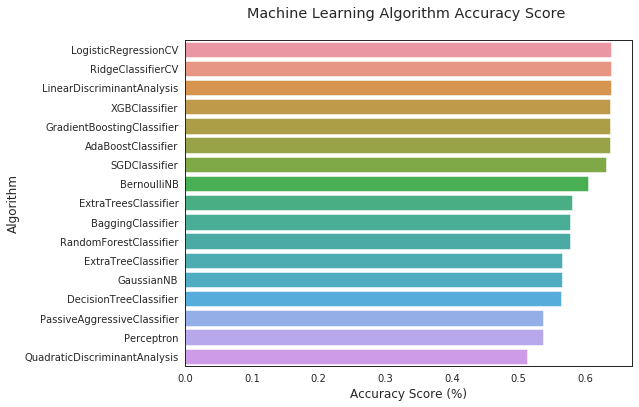

In [86]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
plt.figure(figsize=(8,6))
sns.barplot(x='Accuracy', y = 'ModelName', data = MLA_compare[MLA_compare['Dataset']== 'ValidSet'], palette=sns.husl_palette(n_colors=20,l=.7))

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

In [93]:
top_models = MLA_compare[:4]['ModelName'].values # 상위 4개 모델 Tuninig
top_models

array(['LogisticRegressionCV', 'RidgeClassifierCV',
       'LinearDiscriminantAnalysis', 'XGBClassifier'], dtype=object)

In [0]:
# TEST SET 결과 출력 사용자 함수
def result_summary(model, x, y):
  pred_y = model.predict(x)
  pred_y = (pred_y_lr>0.5)
  print("Accuracy: {:.4f}".format(accuracy_score(y, pred_y)))
  print("Confusion Matrix: \n", confusion_matrix(y, pred_y))
  print("Classification Report Matrix: \n", classification_report(y, pred_y, digits=3))

  roc_auc = roc_auc_score(y, pred_y)
  print("roc_auc score is : {:.4f}".format(roc_auc))

  fpr, tpr, threshold = roc_curve(y, pred_y)
  roc_auc = auc(fpr, tpr)

  auc_graph(roc_auc, fpr, tpr)

In [113]:
lr_clf = linear_model.LogisticRegression()
lr_clf.fit(train_x, train_y)

param_grid = {}
param_grid["C"] =  [0.01, 0.1, 10, 100]
param_grid["fit_intercept"] =  [True, False]
param_grid["warm_start"] = [True,False]
param_grid["random_state"] = [1]

grid_lr_clf = GridSearchCV(lr_clf, param_grid)

grid_lr_clf.fit(train_x, train_y)
print(grid_lr_clf.best_estimator_)

base_mdl = result_summary(lr_clf, test_x, test_y)
grid_mdl = result_summary(grid_lr_clf.best_estimator_, test_x, test_y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=True)

Accuracy: 0.6385
Confusion Matrix: 
 [[6324 3308]
 [3674 6006]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.633     0.657     0.644      9632
         1.0      0.645     0.620     0.632      9680

    accuracy                          0.638     19312
   macro avg      0.639     0.639     0.638     19312
weighted avg      0.639     0.638     0.638     19312

roc_auc score is : 0.6385


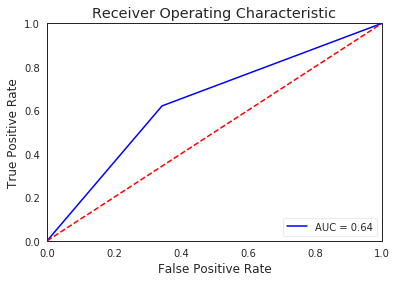

In [120]:
# RidgeClassifier
model_rc = linear_model.RidgeClassifier()

param_grid = {'alpha':[1e-3, 1e-2, 1e-1, 1]}

grid_rc = GridSearchCV(model_rc,param_grid = param_grid, cv=cv_split, scoring="f1", n_jobs= -1, verbose = 1)
grid_rc.fit(train_x, train_y)
grid_rc_best = grid_rc.best_estimator_
print(grid_rc_best)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.3s finished


RidgeClassifier(alpha=0.001, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)


Accuracy: 0.6385
Confusion Matrix: 
 [[6324 3308]
 [3674 6006]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.633     0.657     0.644      9632
         1.0      0.645     0.620     0.632      9680

    accuracy                          0.638     19312
   macro avg      0.639     0.639     0.638     19312
weighted avg      0.639     0.638     0.638     19312

roc_auc score is : 0.6385


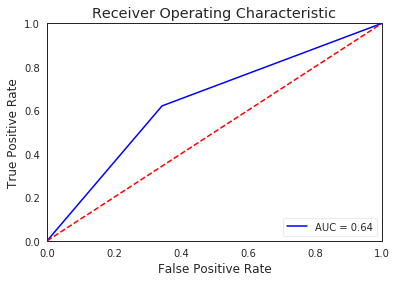

In [121]:
test_results(grid_rc_best, test_x, test_y)

In [125]:
lda_clf = discriminant_analysis.LinearDiscriminantAnalysis()
lda_clf.fit(train_x,train_y)

base_mdl = result_summary(lr_clf, test_x, test_y)

param_grid = {'solver':('svd','lsqr')}
grid_lda_clf = GridSearchCV(lda_clf, param_grid)

grid_lda_clf.fit(train_x, train_y)
lda_clf_best = grid_lda_clf.best_estimator_
print(lda_clf_best)

grid_mdl = result_summary(grid_lr_clf.best_estimator_, test_x, test_y) # LDA from 0.6377 to 0.6393

NameError: ignored

In [97]:
# XGBoost Test
xgb_clf = XGBClassifier(nthreads=-1)

one_to_left = st.beta(100, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.9),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

rand_search = RandomizedSearchCV(xgb_clf, params, n_jobs=-1, cv=5, verbose=1)  
rand_search.fit(train_x, train_y) 
xgb_best = rand_search.best_estimator_
print(rand_search.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.6min finished


KeyboardInterrupt: ignored

In [0]:
model_lr = linear_model.LogisticRegression().fit(train_x, train_y)
pred_y_lr = model_lr.predict(test_x)
pred_y_lr = (pred_y_lr>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_lr)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_lr))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_lr, digits=3))

Accuracy: 0.64012
Confusion Matrix: 
 [[6343 3289]
 [3661 6019]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.634     0.659     0.646      9632
         1.0      0.647     0.622     0.634      9680

    accuracy                          0.640     19312
   macro avg      0.640     0.640     0.640     19312
weighted avg      0.640     0.640     0.640     19312



In [0]:
model_dt = tree.DecisionTreeClassifier().fit(train_x, train_y)
pred_y_dt = model_dt.predict(test_x)
pred_y_dt = (pred_y_dt>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_dt)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_dt))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_dt, digits=3))

Accuracy: 0.56830
Confusion Matrix: 
 [[6167 3465]
 [4872 4808]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.559     0.640     0.597      9632
         1.0      0.581     0.497     0.536      9680

    accuracy                          0.568     19312
   macro avg      0.570     0.568     0.566     19312
weighted avg      0.570     0.568     0.566     19312



In [0]:
model_rf = ensemble.RandomForestClassifier().fit(train_x, train_y)
pred_y_rf = model_rf.predict(test_x)
pred_y_rf = (pred_y_rf>0.5)
print("Accuracy: {:.5f}".format(accuracy_score(test_y, pred_y_rf)))
print("Confusion Matrix: \n", confusion_matrix(test_y, pred_y_rf))
print("Classification Report Matrix: \n", classification_report(test_y, pred_y_rf, digits=3))

Accuracy: 0.58031
Confusion Matrix: 
 [[5817 3815]
 [4290 5390]]
Classification Report Matrix: 
               precision    recall  f1-score   support

         0.0      0.576     0.604     0.589      9632
         1.0      0.586     0.557     0.571      9680

    accuracy                          0.580     19312
   macro avg      0.581     0.580     0.580     19312
weighted avg      0.581     0.580     0.580     19312

